# My First Classification Slides

- Stephen W. Thomas
- Used for MMA 869, MMAI 869, and GMMA 869
- The Easy version - no hard dependencies or packages (but also, less pretty)

In [1]:
import datetime
print(datetime.datetime.now())

2020-10-05 14:03:54.395789


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import itertools
import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.1.


In [4]:
# Create the 'out' directory to store output images
import os
if not os.path.exists('out'):
    os.makedirs('out')

# Read Data


In [5]:
df = pd.read_csv("../data/generated_marketing.csv")
df.info()
df.head()

feature_names = ['Age', 'Income']
X = df[feature_names].to_numpy()
y = df['Bought'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     500 non-null    float64
 1   Income  500 non-null    float64
 2   Bought  500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


,Age,Income,Bought
0,0.748126,1.185890,0
1,-1.645760,-2.933332,1
2,0.279829,0.835401,0
3,0.195853,1.249209,0
4,-1.357053,-1.409123,1


# Splitting the Data

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

type(X_train)
type(y_train)

numpy.ndarray

numpy.ndarray

# Decision Trees

In [7]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=10, min_samples_leaf=10, max_depth=3, max_leaf_nodes=5)
clf.fit(X_train, y_train)

y_pred_dt = clf.predict(X_test)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=5,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=42)

In [8]:
class_names = [str(x) for x in clf.classes_]

## Use the Model to Predict Someone New

In [9]:
clf.predict_proba([[2, 2]])
clf.predict([[2, 2]])

array([[0.93922652, 0.06077348]])

array([0], dtype=int64)

## Model Parameters

Surpisingly, sci-kit learn does not have a function to print the decision tree in text format. (It does have a way to graphical render the three, which we'll do later.) For now, we'll just print a few stats about the tree.

In [10]:
print(clf.tree_.node_count)
print(clf.tree_.impurity)
print(clf.tree_.children_left)
print(clf.tree_.threshold)

9
[0.99971144 0.40077522 0.45449306 0.99107606 0.33050773 0.22746906
 0.83147439 0.28998605 0.        ]
[ 1  5  3 -1 -1  7 -1 -1 -1]
[-0.05775159 -0.15540861  0.2254563  -2.         -2.         -0.7764757
 -2.         -2.         -2.        ]


## Model Performance

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_dt)

array([[50,  5],
       [ 5, 40]], dtype=int64)

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        55
           1       0.89      0.89      0.89        45

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



In [13]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss

print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_dt)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_dt)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_dt)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_dt)))

Accuracy = 0.90
Kappa = 0.80
F1 Score = 0.89
Log Loss = 3.45


## Model Visualization

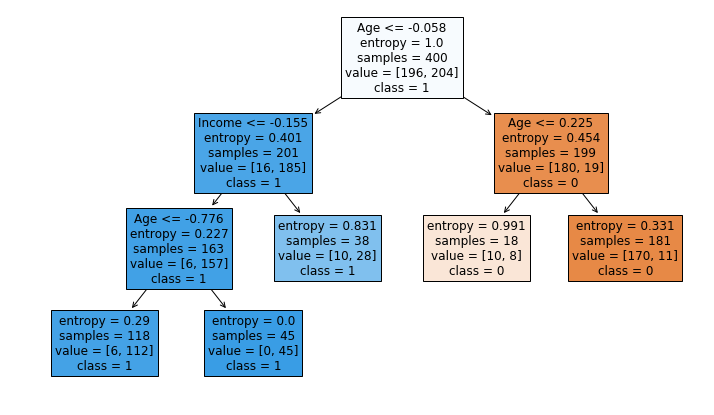

In [14]:
# Needs sklearn 0.21 or higher
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 7));
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names, proportion=False, fontsize=12);
#plt.savefig('out/marketing-dt-tree.png', transparent=False);

## Hyperparameter Tuning

### Grid Search

In [15]:
from sklearn.model_selection import GridSearchCV

treeclf = DecisionTreeClassifier(splitter='best', class_weight=None, random_state=42)
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[2, 10, 20], 'min_samples_leaf':[1, 5, 10],
             'max_features':[None, 'auto'], 'max_leaf_nodes':[None, 10, 50]}
cv_clf = GridSearchCV(treeclf, parameters, scoring='roc_auc', cv=5, return_train_score=True)
%time cv_clf.fit(X, y)

Wall time: 1.69 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [2, 10, 20],
                         'max_features': [None, 'auto'],
                         'max_leaf_nodes': [None, 10, 50],
                         'min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='roc_auc')

In [16]:
cv_clf.best_params_
cv_clf.best_score_
cv_clf.best_estimator_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'min_samples_leaf': 5}

0.9391163345338136

DecisionTreeClassifier(max_depth=20, max_features='auto', max_leaf_nodes=50,
                       min_samples_leaf=5, random_state=42)

# Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)

## Model Parameters

In [18]:
gnb.theta_ # Mean of each feature per class
gnb.sigma_ # Variance of each feature per class

array([[ 0.99887777,  1.06512859],
       [-0.91827636, -1.08561939]])

array([[0.70142311, 0.949339  ],
       [0.62737657, 1.68858577]])

## Model Performance

In [19]:
confusion_matrix(y_test, y_pred_gnb)

array([[51,  4],
       [ 2, 43]], dtype=int64)

In [20]:
print(classification_report(y_test, y_pred_gnb, target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        55
           1       0.91      0.96      0.93        45

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [21]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_gnb)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_gnb)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_gnb)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_gnb)))

Accuracy = 0.94
Kappa = 0.88
F1 Score = 0.93
Log Loss = 2.07


# KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)

y_pred_knn = knn_clf.predict(X_test)

KNeighborsClassifier(n_neighbors=3)

## Model Parameters

In [23]:
knn_clf.effective_metric_
knn_clf.effective_metric_params_

'euclidean'

{}

## Model Performance

In [24]:
print(confusion_matrix(y_test, y_pred_knn))

[[47  8]
 [ 2 43]]


In [25]:
print(classification_report(y_test, y_pred_knn, target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90        55
           1       0.84      0.96      0.90        45

    accuracy                           0.90       100
   macro avg       0.90      0.91      0.90       100
weighted avg       0.91      0.90      0.90       100



In [26]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_knn)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_knn)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_knn)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_knn)))

Accuracy = 0.90
Kappa = 0.80
F1 Score = 0.90
Log Loss = 3.45


# SVM - Linear

In [27]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=0.025)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

SVC(C=0.025, kernel='linear')

## Model Parameters

In [28]:
svm_clf.n_support_

array([70, 69])

In [29]:
svm_clf.support_vectors_

array([[-2.30188062e+00, -1.37169280e+00],
       [-1.18486685e+00, -1.79040549e+00],
       [ 6.59102878e-01, -4.92594995e-02],
       [ 1.88977492e-01,  1.49340633e+00],
       [ 6.32255404e-02,  1.15016778e+00],
       [ 1.23912826e+00, -4.01893060e-01],
       [ 7.49980152e-01, -3.38768128e-01],
       [ 1.23622216e+00,  1.18585351e-01],
       [ 7.19460491e-01,  9.02795935e-01],
       [ 1.95852933e-01,  1.24920912e+00],
       [ 6.24289241e-01,  7.92790019e-01],
       [ 6.76905028e-01, -3.75127816e-01],
       [ 9.03792039e-01,  3.30215452e-01],
       [ 1.27385324e+00, -1.12810817e-02],
       [-8.82249296e-01, -1.76640750e+00],
       [-2.19281611e-02,  1.37013900e+00],
       [ 6.18149343e-01,  8.72452885e-01],
       [ 7.33559474e-01,  3.18524739e-01],
       [ 5.64698788e-01,  8.86571007e-01],
       [-1.13932834e+00,  1.30141500e-01],
       [ 8.88865699e-01,  2.62250487e-01],
       [-1.37872953e+00,  4.40826598e-01],
       [ 8.41265426e-01,  4.54384311e-01],
       [ 1.

In [30]:
svm_clf.dual_coef_ 

array([[-0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.00055246, -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.01900603, -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.0

In [31]:
svm_clf.intercept_ 

array([0.0853027])

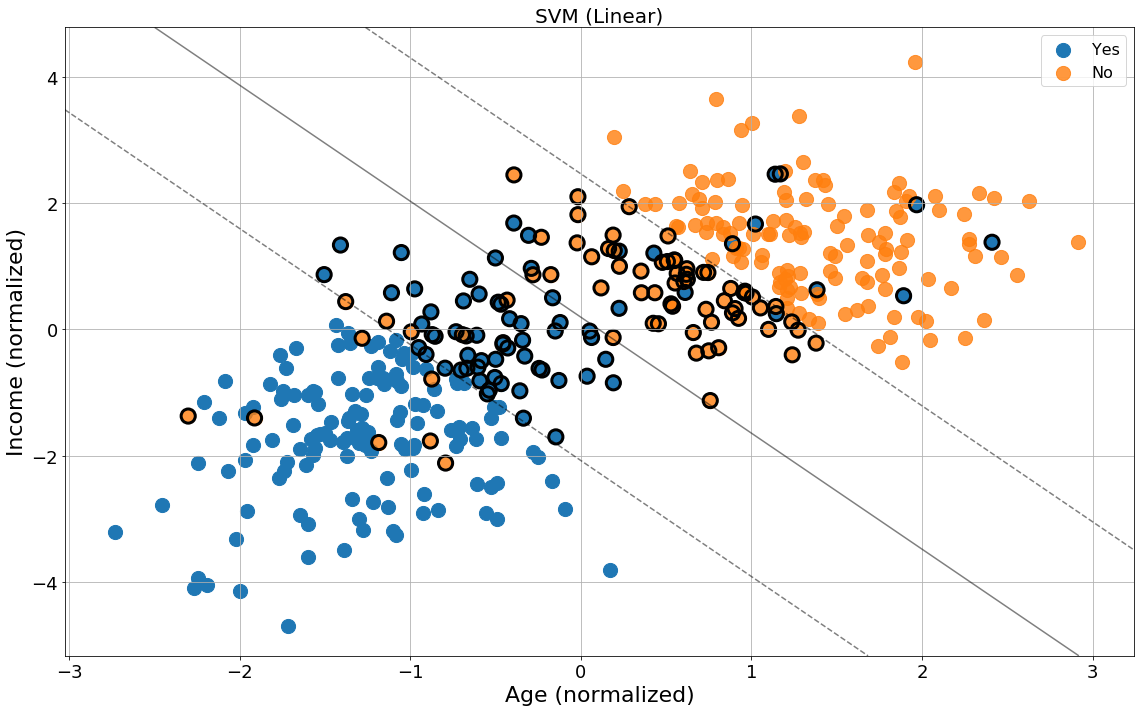

In [32]:
plt.figure(figsize=(16, 10));
plt.grid(True);


ind_d = y_train==1
ind_p = y_train==0
plt.scatter(X_train[ind_d,0], X_train[ind_d,1], marker='o', s=200, label='Yes');
plt.scatter(X_train[ind_p,0], X_train[ind_p,1], marker='o', s=200, label="No", alpha=0.8);

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm_clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# plot support vectors
plt.scatter(svm_clf.support_vectors_[:, 0], svm_clf.support_vectors_[:, 1], s=200, linewidth=3, facecolors='none', edgecolors='k')

plt.legend(fontsize=16);
plt.title("SVM (Linear)", fontsize=20);
plt.xlabel('Age (normalized)', fontsize=22);
plt.ylabel('Income (normalized)', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.tight_layout();

## Model Performance

In [33]:
print(confusion_matrix(y_test, y_pred_svm))

[[51  4]
 [ 2 43]]


In [34]:
print(classification_report(y_test, y_pred_svm, target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        55
           1       0.91      0.96      0.93        45

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [35]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_svm)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_svm)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_svm)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_svm)))

Accuracy = 0.94
Kappa = 0.88
F1 Score = 0.93
Log Loss = 2.07


# NN

In [36]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier(solver='lbfgs', activation='relu', alpha=1e-3, 
                       hidden_layer_sizes=(3), random_state=1, verbose=True)
nn_clf.fit(X_train, y_train)

y_pred_nn = nn_clf.predict(X_test)

MLPClassifier(alpha=0.001, hidden_layer_sizes=3, random_state=1, solver='lbfgs',
              verbose=True)

## Model Parameters

In [37]:
nn_clf.loss_

0.2710649521744611

In [38]:
nn_clf.n_layers_

3

In [39]:
w = nn_clf.coefs_ # The ith element in the list represents the weight matrix corresponding to layer i.
w

[array([[ 0.97565261,  1.08832584, -1.04406553],
        [-1.66548065, -1.62569206, -0.61746919]]),
 array([[ 3.91733103],
        [-2.57062872],
        [ 1.76672827]])]

In [40]:
b = nn_clf.intercepts_ # The ith element in the list represents the bias vector corresponding to layer i + 1.
b

[array([-2.08114864, -1.191515  ,  1.62527184]), array([-2.59817514])]

In [41]:
nn_clf.out_activation_

'logistic'

In [42]:
nn_clf.predict_proba([[0.5, 1]])

array([[0.85068094, 0.14931906]])

## Model Performance

In [43]:
print(confusion_matrix(y_test, y_pred_nn))

[[51  4]
 [ 2 43]]


In [44]:
print(classification_report(y_test, y_pred_nn, target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        55
           1       0.91      0.96      0.93        45

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [45]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_nn)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_nn)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_nn)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_nn)))

Accuracy = 0.94
Kappa = 0.88
F1 Score = 0.93
Log Loss = 2.07
